# Исследование данных рекламы по каналам коммуникации он-лайн кинотеатра

1. Получить данных из разных источников, сформировать единую витрину данных, провести разведочный анализ данных
2. Определить степень сфальсифицированности данных и принять решение об их использовании 
3. Исследовать 
    - 3.1. корреляцию признаков, факторный анализ, фродовые данные, сделать выводы, дать рекомендации
    - 3.2. воронку продаж по каналам коммуникации, сделать выводы, дать рекомендации
    - 3.3. затраты и прибыль по рекламным каналам, сделать выводы, дать рекомендации
    - 3.4. операционные системы пользователей по каналам коммуникации, сделать выводы, дать рекомендации

### Описание задачи и исходных данных
- Клиент: онлайн-кинотеатр, предоставляющий к просмотру как фильмы и сериалы, так и мультфильмы. 
- Процесс: В течение месяца клиент провёл серию рекламных кампаний и теперь хочет оценить, какой вклад в итоговый трафик они внесли
- На основании всех полученных от клиента данных нужно выявить проблемные этапы воронки продаж, определить причины этого и дать рекомендации по изменению подходов к продажам
### Исходные данные
Данные от клиента в виде двух таблиц
- Структура таблиц с данными различных каналов:
    - user_id: зашифрованный идентификатор пользователя;
    - funnel_stage: этап воронки;
    - timestamp: время совершения действия юзером;
    - profit: прибыль на этапе покупки, в остальных случаях маркируется как None;
    - price: затраты на рекламу;
    - os: операционная система, которой пользуется человек.
- Структура таблицы с ценами на рекламу:
    - ad_channel: название рекламного канала;
    - price: стоимость рекламы.
    
Этапы воронки:
-	awareness — осведомлённость (факт показа рекламы); в нашей таблице этот этап воронки пропущен;
-	interest — интерес (клик по рекламному баннеру и переход на сайт);
-	consideration — рассмотрение к покупке (выбор планов подписки, хождение по продуктовым страницам);
-	intent — намерение купить (выбор плана, заявка на обратную связь, регистрация);
-	purchase — покупка.

Онлайн-кинотеатр отслеживает различные каналы коммуникации со своими клиентами: как органический трафик, поступающий от прямых переходов по ссылкам или из поисковой выдачи, так и рекламный трафик от баннеров и партнёрских сетей.
Описание каналов коммуникации:
-	banner — баннерная реклама на сайтах;
-	video — рекламные видеоролики;
-	native — нативные баннеры;
-	partner_network — реклама партнёрской сети, размещается на агрегаторах контента;
-	rich — брендирование страницы, большой баннер на весь экран;
-	search — платный поиск;
-	organic_traffic — переходы по прямым ссылкам или переходы с бесплатной поисковой выдачи на сайт.

Также предоставляются данные о затратах на различные рекламные каналы.

In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import warnings
import scipy.stats as st

from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer import FactorAnalyzer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder 

In [2]:
warnings.filterwarnings('ignore')

## 1. Получение и первичное исследование исходных данных

### 1.1.  Получение исходных данных
- Поступили разрозненные файлы с данными о действиях людей на каждом этапе воронки по нескольким рекламным кампаниям. В каждом файле хранится информация о каждом отдельном канале коммуникации, файлы опознаются по названиям рекламных кампаний
- Также в отдельном файле есть информация о затратах на рекламные кампании
- Надо собрать данные в единую Excel-таблицу со следующей структурой:
    - user_id: зашифрованный идентификатор пользователя;
    - ad_channel: канал коммуникации (например, поиск, видеореклама, баннерная реклама, партнёрские сети, органический трафик сайта), добавить название канала коммуникации, взяв его из соответствующего названия файла;
    - funnel_stage: этап воронки;
    - price: затраты на рекламу;
    - profit: прибыль на этапе покупки, в остальных случаях маркируется как None;
    - os: операционная система, которой пользуется человек;
    - timestamp: время совершения действия юзером.
- Итоговую таблицу отсортировать по колонке timestamp

In [3]:
# Получаем исходные данные с учетом типа файла
df_search = pd.read_csv("data/search.csv", index_col=0)
df_organic_traffic = pd.read_csv("data/organic_traffic.csv", index_col=0, header=None,
                                 names=["user_id", "funnel_stage", "timestamp", "profit", "os"])
df_partner_network = pd.read_csv("data/partner_network.csv", index_col=0, header=None,
                                 names=["user_id", "funnel_stage", "timestamp", "profit", "os"])
df_rich = pd.read_excel("data/rich.xlsx")
df_banner = pd.read_excel("data/banner.xlsx")
df_video = pd.read_csv("data/video.csv", index_col=0, delimiter=",")
df_native = pd.read_csv("data/native.csv", index_col=0, delimiter=",")
df_other = pd.read_csv("data/other.csv", index_col=0, delimiter=",")
ad_dict = pd.read_json("data/advertising_information.json")

In [4]:
# Преобразуем исходные файлы с каналами коммуникаций и объединяем в одну таблицу
df_search["ad_channel"] = "search"
df_organic_traffic["ad_channel"] = "organic_traffic"
df_partner_network["ad_channel"] = "partner_network"
df_rich["ad_channel"] = "rich"
df_banner["ad_channel"] = "banner"
df_video["ad_channel"] = "video"
df_native["ad_channel"] = "native"
df_other["ad_channel"] = "other"
df = pd.concat([df_search, df_organic_traffic,
                df_partner_network, df_rich,
                df_banner, df_video, df_native, df_other])
df = df.merge(ad_dict.set_index('ad_channel'), on='ad_channel')
print(df.shape)
df.head()

(3845707, 7)


,user_id,funnel_stage,timestamp,profit,os,ad_channel,price
0,387356,INTEREST,150000,NaN,iOS,search,1.5
1,619571,CONSIDERATION,150000,NaN,iOS,search,1.5
2,230119,INTEREST,150000,NaN,iOS,search,1.5
3,399556,INTEREST,150000,NaN,iOS,search,1.5
4,556959,INTEREST,150001,NaN,Android,search,1.5


In [76]:
ad_dict

,ad_channel,price
0,search,1.50
1,banner,0.50
2,video,0.75
3,native,2.00
4,partner_network,1.00
5,rich,2.50
6,organic_traffic,0.00
7,other,NaN


In [5]:
# Сохраняем файл в csv, т.к. в Excel не входит
df.to_csv("reklam_data.csv", index=None)

### 1.2. Проверка качества данных

1. Проверка на пропуски и ошибки в данных
2. Клиента не интересуют данные, поступившие от канала «Другое»
3. Анализ уникальных пользователей по каждому рекламному каналу по этапам воронки продаж
4. Анализ данных на фальсификацию. Клиент считает, что данные некоторых этапов воронки продаж могли быть сфальсифицированы «накликиванием». Проверить, удалить строки с фродовыми данными (анализ - сколько действий в один момент времени совершает пользователь), сохранить фродовые данные в отдельную таблицу.

#### 1.2.1. Проверка и заполнение пропущенных данных

In [3]:
df = pd.read_csv('reklam_data.csv')
df

,user_id,funnel_stage,timestamp,profit,os,ad_channel,price
0,387356,INTEREST,150000,NaN,iOS,search,1.5
1,619571,CONSIDERATION,150000,NaN,iOS,search,1.5
2,230119,INTEREST,150000,NaN,iOS,search,1.5
3,399556,INTEREST,150000,NaN,iOS,search,1.5
4,556959,INTEREST,150001,NaN,Android,search,1.5
...,...,...,...,...,...,...,...
3845702,551827,intent,212778,NaN,iOS,other,NaN
3845703,357210,consideration,213933,NaN,Android,other,NaN
3845704,655650,intent,216711,NaN,Android,other,NaN
3845705,749522,interest,217120,NaN,Android,other,NaN


In [12]:
# Смотрим содержание таблицы: количество уникальных значений в столбцах, их список
for column in df:
    print('')
    print('Характеристика:', column)
    uniqvalue = df[column].nunique()
    print('Количество уникальных значений: ', uniqvalue)
    print('Список значений: ',  df[column].value_counts())


Характеристика: user_id
Количество уникальных значений:  531791
Список значений:  788968    3402
882758    3355
877835    3313
50025     3309
692503    3309
          ... 
421890       1
171467       1
925931       1
756739       1
387356       1
Name: user_id, Length: 531791, dtype: int64

Характеристика: funnel_stage
Количество уникальных значений:  8
Список значений:  interest         1969204
INTEREST         1250609
consideration     201144
INTENT            162610
CONSIDERATION     138962
intent            118301
PURCHASE            3112
purchase            1765
Name: funnel_stage, dtype: int64

Характеристика: timestamp
Количество уникальных значений:  60736
Список значений:  174734    1735
188033    1704
186845    1695
173384    1694
173866    1682
          ... 
213078       1
213086       1
213088       1
213097       1
219223       1
Name: timestamp, Length: 60736, dtype: int64

Характеристика: profit
Количество уникальных значений:  6
Список значений:  1099.0    867
260.0  

#### Аномальных данных не выявлено

In [13]:
# Проверим количество пропущенных значений по столбцам

missing_values = ((df.isna().sum()/len(df))*100).sort_values(ascending=False)
print('Процент пропущенных значений: ')
missing_values

Процент пропущенных значений: 


profit          99.873183
price            0.587356
user_id          0.000000
funnel_stage     0.000000
timestamp        0.000000
os               0.000000
ad_channel       0.000000
dtype: float64

<AxesSubplot:>

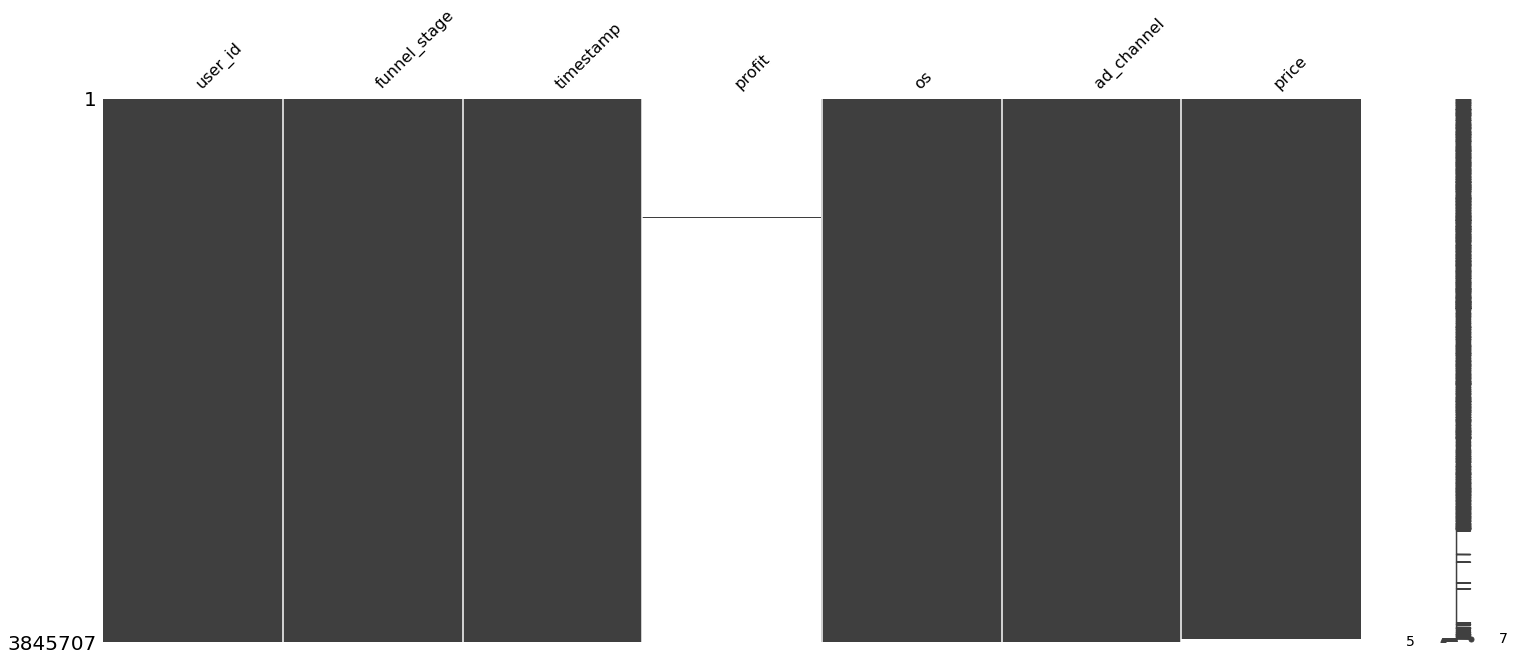

In [5]:
msno.matrix(df)

#### Действия - 
1. Заменить значения в "funnel_stage" с прописных на строчные, для унификации значений
2. Заменить пустые значения в "profit" на нулевые (по смыслу)
3. Исключить из выборки строки с пустым значением столбца "price"

In [4]:
df['funnel_stage'] = df['funnel_stage'].str.lower()
df.funnel_stage.value_counts(normalize=True)

interest         0.837249
consideration    0.088438
intent           0.073045
purchase         0.001268
Name: funnel_stage, dtype: float64

In [5]:
df['profit'] = df['profit']. fillna (0)

In [6]:
f = df[(df['price'].isnull())].shape[0]
print(f'Количество объектов с пустой ценой  -- {f}')
f3 = df[(df['price'].isnull()) & (df['ad_channel'] == "other")].shape[0]
print(f'Количество объектов с пустой ценой и каналом "Другое" -- {f3}')
f1 = df[(df['price'].isnull() & (df['profit'] > 0))].shape[0]
print(f'Количество объектов с пустой ценой с profit > 0 -- {f1}')
f2 = df[(df['price'].isnull() & (df['profit'] > 0) & (df['ad_channel'] == "other"))].shape[0]
print(f'Количество объектов с пустой ценой с profit > 0 от канала "Другое" -- {f2}')
f4 = df[(df['profit'] > 0)].shape[0]
print(f'Количество объектов с profit > 0 -- {f4}')

Количество объектов с пустой ценой  -- 22588
Количество объектов с пустой ценой и каналом "Другое" -- 22588
Количество объектов с пустой ценой с profit > 0 -- 43
Количество объектов с пустой ценой с profit > 0 от канала "Другое" -- 43
Количество объектов с profit > 0 -- 4877


In [7]:
# В связи с незначительностью данных, можем пренебречь всеми строками с отсутствующими ценами
df = df.dropna(subset=['price'])
f = df[(df['price'].isnull())].shape[0]
print(f'Количество объектов с пустой ценой  -- {f}')

Количество объектов с пустой ценой  -- 0


In [36]:
# Проверяем заполненность базы
def print_useful_rows_info(df):
    print('Количество полностью заполненных объектов из всей выборки: ', len(df.dropna()))
    print('Процент полностью заполненных объектов из всей выборки: ', round(len(df.dropna())/len(df) * 100, 2))
print_useful_rows_info(df)

Количество полностью заполненных объектов из всей выборки:  3823119
Процент полностью заполненных объектов из всей выборки:  100.0


In [8]:
# Клиент уточнил, что данные, поступившие от канала «Другое», его не интересуют. Проверим, остались ли такие данные
a = df[(df['ad_channel'] == "other")].shape[0]
print(f'Количество объектов с каналом "Другое" -- {a}')

Количество объектов с каналом "Другое" -- 0


#### 1.2.2. Проверка на дублирование

In [9]:
df['funnel_stage'] = np.where(df['funnel_stage'] == 'interest', '1_interest', np.where(df['funnel_stage'] == 'consideration', '2_consideration', np.where(df['funnel_stage'] == 'intent', '3_intent', '4_purchase')))

In [10]:
# Установим количество дублирующих строк в базе

duplicateRows = df[df.duplicated ()]
print(f'Количество полностью дублирующих строк в базе - {(duplicateRows.shape[0])}') 
duplicateRows

Количество полностью дублирующих строк в базе - 2831380


,user_id,funnel_stage,timestamp,profit,os,ad_channel,price
155,910643,1_interest,150029,0.0,iOS,search,1.5
156,910643,1_interest,150029,0.0,iOS,search,1.5
157,910643,1_interest,150029,0.0,iOS,search,1.5
158,910643,1_interest,150029,0.0,iOS,search,1.5
159,910643,1_interest,150029,0.0,iOS,search,1.5
...,...,...,...,...,...,...,...
3822884,581069,1_interest,205862,0.0,iOS,native,2.0
3822885,581069,1_interest,205862,0.0,iOS,native,2.0
3822886,581069,1_interest,205862,0.0,iOS,native,2.0
3822887,581069,1_interest,205862,0.0,iOS,native,2.0


Таким образом, почти 74% данных дублируются, т.е. к данным есть явные вопросы. 
Дублирование следут удалить, но пока ничего не делаем, определяем фродовые данные

In [11]:
# Удалим из базы полностью дублирующие строки
df_without_double = df.drop_duplicates ()
df_without_double

,user_id,funnel_stage,timestamp,profit,os,ad_channel,price
0,387356,1_interest,150000,0.0,iOS,search,1.5
1,619571,2_consideration,150000,0.0,iOS,search,1.5
2,230119,1_interest,150000,0.0,iOS,search,1.5
3,399556,1_interest,150000,0.0,iOS,search,1.5
4,556959,1_interest,150001,0.0,Android,search,1.5
...,...,...,...,...,...,...,...
3823114,1045450,2_consideration,211055,0.0,iOS,native,2.0
3823115,783513,3_intent,211273,0.0,iOS,native,2.0
3823116,292776,3_intent,211612,0.0,iOS,native,2.0
3823117,815870,1_interest,211930,0.0,Android,native,2.0


### Выводы по итогам первичного разведочного анализа
Объектов с каналом "Другое" в базе не осталось, так как они все были с пустой ценой. Строки с пустой ценой были удалены предыдущим действием

Таким образом в таблице все данные заполнены, пропущенных нет.
74% данных - дубли, к удалению

#### 1.2.3.  Уникальные пользователи по рекламным каналам в разрезе этапов воронки продаж. Оценка результата

In [49]:
df_without_double.drop(columns=['timestamp', 'profit', 'os', 'price', 'ad_channel']).groupby(['funnel_stage']).count()

,user_id
funnel_stage,
1_interest,597381
2_consideration,338293
3_intent,51231
4_purchase,4834


In [50]:
df_without_double.drop(columns=['timestamp', 'profit', 'os', 'price']).groupby(['funnel_stage', 'ad_channel']).count()

user_id
funnel_stage    ad_channel              
1_interest      banner             93443
                native             19685
                organic_traffic    79990
                partner_network    67212
                rich                9088
                search            228197
                video              99766
2_consideration banner             47541
                native             12597
                organic_traffic    53592
                partner_network    24721
                rich                4657
                search            134305
                video              60880
3_intent        banner              7743
                native               418
                organic_traffic     9299
                partner_network     4504
                rich                1252
                search             27955
                video                 60
4_purchase      banner               688
                native                37
                organic_traffic      542
                partner_network      450
                rich                  22
                search              3090
                video                  5

#### 1.2.4. Проверка данных на фальсификацию
Клиент считает, что данные некоторых этапов воронки продаж могли быть сфальсифицированы «накликиванием». Проверить, удалить строки с фродовыми данными (анализ - сколько действий в один момент времени совершает пользователь), сохранить фродовые данные в отдельную таблицу

#### 1.2.4.1. Расчет действий пользователя в один момент времени 

In [51]:
df_without_double

,user_id,funnel_stage,timestamp,profit,os,ad_channel,price
0,387356,1_interest,150000,0.0,iOS,search,1.5
1,619571,2_consideration,150000,0.0,iOS,search,1.5
2,230119,1_interest,150000,0.0,iOS,search,1.5
3,399556,1_interest,150000,0.0,iOS,search,1.5
4,556959,1_interest,150001,0.0,Android,search,1.5
...,...,...,...,...,...,...,...
3823114,1045450,2_consideration,211055,0.0,iOS,native,2.0
3823115,783513,3_intent,211273,0.0,iOS,native,2.0
3823116,292776,3_intent,211612,0.0,iOS,native,2.0
3823117,815870,1_interest,211930,0.0,Android,native,2.0


In [12]:
# Количество пользователей в датафрейме и количество пользователей совершавших более 1 действия в один момент времени - 

x = df_without_double.groupby(['user_id']).size().shape[0] 
print(f'Количество пользователей в датафрейме -- {x}')

df_user_more_one_action = (df_without_double.groupby(['user_id', 'timestamp']).size() 
   .sort_values(ascending=False) 
   .reset_index(name='count'))
a = df_user_more_one_action[(df_user_more_one_action['count'] > 1)].shape[0]
print(f'Количество пользователей, совершавших более 1 действия в один момент времени -- {a}')

Количество пользователей в датафрейме -- 529359
Количество пользователей, совершавших более 1 действия в один момент времени -- 5175


#### 1.2.4.2. Гистограмма числа действий, совершаемых пользователями в один момент времени

<AxesSubplot:ylabel='Density'>

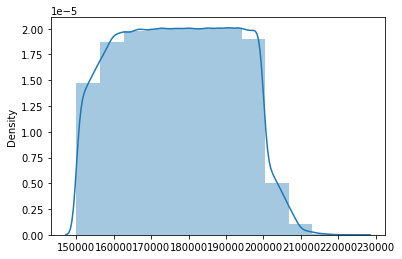

In [56]:
# Визуализируем распределение количества событий во времени - 
sns.distplot(df_without_double.timestamp.values, bins=12)

<AxesSubplot:ylabel='Density'>

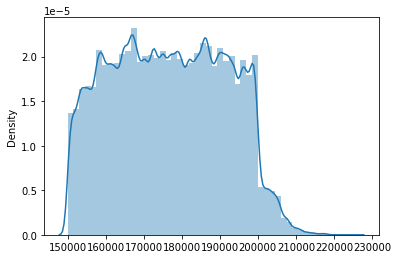

In [48]:
# Для сравнения - так выглядит тоже распределение, но без удаления дублирующих строк - 
sns.distplot(df.timestamp.values, bins=12)

Как видно из графиков - удаление дублей существенно улучшило качество исходной информации

#### 1.2.4.3. Процент фродовых пользователей от общего числа. Сохраняем фродовые данные

In [53]:
print(f'Процент фродовых записей от общего числа - {round(a/x*100,2)}%')

Процент фродовых записей от общего числа - 0.98%


In [59]:
# Сохраняем фродовые данные в отдельную таблицу

frod_duplic = df_without_double[df_without_double.duplicated(['user_id', 'timestamp'])]
frod_duplic

,user_id,funnel_stage,timestamp,profit,os,ad_channel,price
160,910643,1_interest,150029,0.0,Android,search,1.5
985,151759,1_interest,150081,0.0,iOS,search,1.5
1698,683700,1_interest,150126,0.0,iOS,search,1.5
2369,707221,3_intent,150162,0.0,Android,search,1.5
2902,572035,1_interest,150168,0.0,Android,search,1.5
...,...,...,...,...,...,...,...
3819135,1464,1_interest,199880,0.0,Android,native,2.0
3819942,277667,1_interest,201019,0.0,iOS,native,2.0
3820911,457564,1_interest,203385,0.0,Android,native,2.0
3821755,328937,1_interest,205627,0.0,Android,native,2.0


In [60]:
# Сохраняем тааблицу без фродовых данных

df_without_frod = df_without_double.drop_duplicates (subset=['user_id', 'timestamp'])
df_without_frod

,user_id,funnel_stage,timestamp,profit,os,ad_channel,price
0,387356,1_interest,150000,0.0,iOS,search,1.5
1,619571,2_consideration,150000,0.0,iOS,search,1.5
2,230119,1_interest,150000,0.0,iOS,search,1.5
3,399556,1_interest,150000,0.0,iOS,search,1.5
4,556959,1_interest,150001,0.0,Android,search,1.5
...,...,...,...,...,...,...,...
3823114,1045450,2_consideration,211055,0.0,iOS,native,2.0
3823115,783513,3_intent,211273,0.0,iOS,native,2.0
3823116,292776,3_intent,211612,0.0,iOS,native,2.0
3823117,815870,1_interest,211930,0.0,Android,native,2.0


In [61]:
# Итоговая фродовая таблица  - дубли + фроды по времени

df_frod = pd.concat([duplicateRows, frod_duplic])
df_frod

,user_id,funnel_stage,timestamp,profit,os,ad_channel,price
155,910643,1_interest,150029,0.0,iOS,search,1.5
156,910643,1_interest,150029,0.0,iOS,search,1.5
157,910643,1_interest,150029,0.0,iOS,search,1.5
158,910643,1_interest,150029,0.0,iOS,search,1.5
159,910643,1_interest,150029,0.0,iOS,search,1.5
...,...,...,...,...,...,...,...
3819135,1464,1_interest,199880,0.0,Android,native,2.0
3819942,277667,1_interest,201019,0.0,iOS,native,2.0
3820911,457564,1_interest,203385,0.0,Android,native,2.0
3821755,328937,1_interest,205627,0.0,Android,native,2.0


In [62]:
df_without_frod.to_csv("df_without_frod.csv", index=None)

In [63]:
frod_duplic.to_csv("df_frod.csv", index=None)

### Выводы по итогам оценки фальсификации данных
После удаления дублей число данных для исследований составлио 30% от начального.
Число фродовых данных составило 5175, или 0,98% от оставшегося числа данных

In [57]:
# Смотрим содержание таблицы: количество уникальных значений в столбцах, их список
for column in df:
    print('')
    print('Характеристика:', column)
    uniqvalue = df[column].nunique()
    print('Количество уникальных значений: ', uniqvalue)
    print('Список значений: ',  df[column].value_counts())


Характеристика: user_id
Количество уникальных значений:  529359
Список значений:  968214    24
803713    12
804597    12
883938    12
141841    12
          ..
13727      1
643304     1
456833     1
93510      1
846645     1
Name: user_id, Length: 529359, dtype: int64

Характеристика: funnel_stage
Количество уникальных значений:  4
Список значений:  1_interest         592623
2_consideration    338293
3_intent            50814
4_purchase           4834
Name: funnel_stage, dtype: int64

Характеристика: timestamp
Количество уникальных значений:  60724
Список значений:  189909    40
173293    40
176310    39
171082    39
199440    39
          ..
213241     1
213247     1
213250     1
213253     1
212116     1
Name: timestamp, Length: 60724, dtype: int64

Характеристика: profit
Количество уникальных значений:  7
Список значений:  0.0       981730
1099.0       859
260.0        849
520.0        841
2136.0       826
130.0        733
50.0         726
Name: profit, dtype: int64

Характеристика

In [59]:
df_without_double.head(3)

,user_id,funnel_stage,timestamp,profit,os,ad_channel,price
0,387356,1_interest,150000,0.0,iOS,search,1.5
1,619571,2_consideration,150000,0.0,iOS,search,1.5
2,230119,1_interest,150000,0.0,iOS,search,1.5


In [61]:
df_without_double['os_']= np.where(df_without_double['os'] == 'iOS', 1, 2)
df_without_double.head(3)

,user_id,funnel_stage,timestamp,profit,os,ad_channel,price,os_
0,387356,1_interest,150000,0.0,iOS,search,1.5,1
1,619571,2_consideration,150000,0.0,iOS,search,1.5,1
2,230119,1_interest,150000,0.0,iOS,search,1.5,1


In [64]:
user = df_without_double.groupby(['user_id']).agg({'funnel_stage': 'size', 'profit': 'mean', 'os_': 'mean'}).reset_index()
user.head()

,user_id,funnel_stage,profit,os_
0,2,1,0.0,1.000000
1,3,1,0.0,1.000000
2,4,1,0.0,2.000000
3,5,2,0.0,1.500000
4,7,3,0.0,1.333333


In [70]:
user['os_'].nunique()

40

In [58]:
# Исследование по os
df_without_double.drop(columns=['timestamp', 'profit', 'funnel_stage', 'ad_channel', 'price']).groupby(['os']).count()

,user_id
os,
Android,521564
iOS,470175


In [72]:
# Исследование по timestamp
df_without_double.drop(columns=['os', 'os_', 'profit', 'funnel_stage', 'ad_channel', 'price']).groupby(['timestamp']).count()

,user_id
timestamp,
150000,16
150001,9
150002,11
150003,15
150004,10
...,...
224682,1
225430,1
225482,1


In [ ]:
df_without_double.drop(columns=['timestamp', 'profit', 'os', 'price']).groupby(['funnel_stage', 'ad_channel']).count()

In [ ]:
product_max_cost = product_cl.groupby(['product']).agg({'id': 'size', 'cost': 'mean', 'base_sale': 'sum'}).reset_index().sort_values(by='cost', ascending = False)
product_max_cost.head(5)

In [74]:
df_without_double_

0          150000
1          150000
2          150000
3          150000
4          150001
            ...  
3823114    211055
3823115    211273
3823116    211612
3823117    211930
3823118    212116
Name: timestamp, Length: 991739, dtype: int64

## 2. Факторный анализ

#### 2.1. Перекодировка значений

проводить факторный и корреляционный анализ средствами Python,
выполнять качественную интерпретацию результатов и устанавливать связь с бизнес-показателями.

Что нужно сделать
Клиенту интересно узнать, есть ли какие-то зависимости в данных. Какие неочевидные признаки могут влиять на выгоду, которую он получает?

Часто признаки, с которыми приходится работать, являются категориальными, и для них также требуется находить какие-то зависимости. Перекодируйте значения вашей таблицы, относящиеся к операционной системе и этапам воронки, в бинарный и нумерованный вид в зависимости от этапа соответственно.
Примените метод factorize из библиотеки Pandas и посчитайте корреляции стандартным способом. Нарисуйте матрицу с помощью библиотеки Seaborn. Посчитайте корреляцию для цены и идентификатора пользователя с помощью коэффициента Пирсона.
Воспользуйтесь методом LabelEncoder из библиотеки Sklearn и закодируйте значения рекламных каналов. Проведите факторный анализ, опираясь на информацию, полученную в модуле. Не забудьте применить метод factorize к колонкам вашей таблицы, прежде чем проводить тест Бартлетта.
Сделайте выводы на основе полученных результатов.


In [55]:
# Работаем на таблице без фродовых значений
df = pd.read_csv('df_without_frod.csv')
print(df.shape)
df.head(3)

(986564, 7)


,user_id,funnel_stage,timestamp,profit,os,ad_channel,price
0,387356,1_interest,150000,0.0,iOS,search,1.5
1,619571,2_consideration,150000,0.0,iOS,search,1.5
2,230119,1_interest,150000,0.0,iOS,search,1.5


In [8]:
# Перекодировка значений операционной системы в бинарный вид, значений этапов воронки - в нумерованный вид
df.loc[df["os"] == "Android", "os"] = 1
df.loc[df["os"] == "iOS", "os"] = 0
df.loc[df["funnel_stage"] == "1_interest", "funnel_stage"] = 1
df.loc[df["funnel_stage"] == "2_consideration", "funnel_stage"] = 2
df.loc[df["funnel_stage"] == "3_intent", "funnel_stage"] = 3
df.loc[df["funnel_stage"] == "4_purchase", "funnel_stage"] = 4
df[["os", "funnel_stage"]] = df[["os", "funnel_stage"]].astype(int)
df.head(3)

,user_id,funnel_stage,timestamp,profit,os,ad_channel,price
0,387356,1,150000,0.0,0,search,1.5
1,619571,2,150000,0.0,0,search,1.5
2,230119,1,150000,0.0,0,search,1.5


#### 2.2. Исследование корреляции факторов

In [9]:
# Факторизация данных таблицы
df_ = df.apply(lambda x: pd.factorize (x)[0])
df_.corr()

,user_id,funnel_stage,timestamp,profit,os,ad_channel,price
user_id,1.000000,-0.059581,0.224156,-0.039106,0.179289,0.852489,0.852489
funnel_stage,-0.059581,1.000000,0.054047,0.258563,-0.013236,-0.075386,-0.075386
timestamp,0.224156,0.054047,1.000000,0.017894,-0.001779,-0.012389,-0.012389
profit,-0.039106,0.258563,0.017894,1.000000,-0.008255,-0.033879,-0.033879
os,0.179289,-0.013236,-0.001779,-0.008255,1.000000,0.184286,0.184286
ad_channel,0.852489,-0.075386,-0.012389,-0.033879,0.184286,1.000000,1.000000
price,0.852489,-0.075386,-0.012389,-0.033879,0.184286,1.000000,1.000000


<AxesSubplot:>

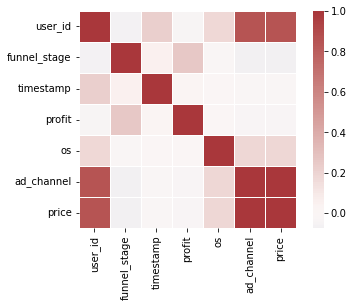

In [10]:
# Тепловая карта корреляции факторов

sns.heatmap(df_.corr(), cmap='vlag', center=0, square=True, linewidths=.5)

In [11]:
# Расчет корреляции для цены и идентификатора пользователя с помощью коэффициента Пирсона

r, p = st.pearsonr(df_['price'], df_['user_id'])

print("Коэффициент корреляции Пирсона:", r)
print("Значение p-value:", p)

Коэффициент корреляции Пирсона: 0.8524890377210477
Значение p-value: 0.0


### Выводы по оценке корреляции цены и id пользователя
Результаты расчета по методам - практически одинаковые, поэтому применяем корреляцию по Пирсону

Несмотря на то, что коэффициент корреляции очень высокий - 0,85, его достоверность =0, т.е. судить о том, что цена канала зависит от идентификатора пользователя некорректно.

#### 2.3. Общий факторный анализ

In [14]:
# Кодировка значений рекламных каналов
df1 = df[['user_id', 'funnel_stage', 'timestamp', 'os', 'ad_channel', 'price', 'profit']]
labelencoder = LabelEncoder()
df1.loc[:, 'ad_channel'] = labelencoder.fit_transform(df1.loc[:, 'ad_channel'])
df1.head(3)

,user_id,funnel_stage,timestamp,os,ad_channel,price,profit
0,387356,1,150000,0,5,1.5,0.0
1,619571,2,150000,0,5,1.5,0.0
2,230119,1,150000,0,5,1.5,0.0


In [15]:
X = df1.iloc[:, :-1]
y = df1.iloc[:, -1]
X.corrwith(y)

user_id         0.023185
funnel_stage    0.203064
timestamp       0.014288
os             -0.006270
ad_channel      0.000850
price           0.012924
dtype: float64

In [16]:
# Тест Бартлета показывает возможность выполнения факторного анализа - p_value = 0.
# Нулевая гипотеза об отсутствии корреляции между переменными отвергается, что означает
# что в выборке существуют значимые корреляции по крайней мере между некоторыми из переменных.

chi_square_value, p_value=calculate_bartlett_sphericity(X)
chi_square_value, p_value

(360924.1218571494, 0.0)

<AxesSubplot:>

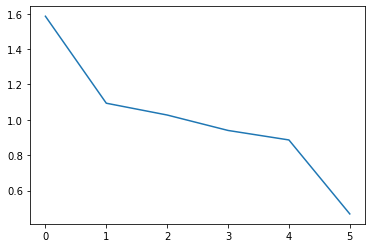

In [17]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)
fa = FactorAnalyzer(n_factors=3)
fa.fit(X_sc)
ev, v = fa.get_eigenvalues()
sns.lineplot(data=ev)

In [18]:
# Два фактора из 5  имеют значения больше 1

n_factors = 2
fa = FactorAnalyzer(n_factors = n_factors)
fa.fit(X_sc)
loadings = pd.DataFrame(fa.loadings_, index = X.columns, 
                        columns = ['factor_{x}'.format(x = x + 1) for x in range(n_factors)])

In [19]:
loadings.sort_values(by='factor_2', ascending=False)

,factor_1,factor_2
user_id,-0.025308,0.579600
funnel_stage,0.005842,0.076615
price,0.988214,0.060782
timestamp,-0.000801,0.017767
os,-0.218092,-0.080403
ad_channel,0.525504,-0.186476


##### Таким образом, фактор 2 выделяет существенное влияние идентификатора пользователя

In [20]:
X_tr = pd.DataFrame(fa.transform(X_sc))
X_tr

,0,1
0,0.855079,-0.229205
1,0.834539,0.255535
2,0.872425,-0.503881
3,0.853734,-0.207893
4,0.847292,-0.019914
...,...,...
986559,1.603277,1.605030
986560,1.637279,1.226727
986561,1.691461,0.369755
986562,1.634564,1.038658


#### 2.5. Общие выводы факторного анализа

 Матрица корреляций выделяет основные коррелирующие переменные с результатом - это рекламный канал и его цена. Остальные переменные имеют крайне низкую корреляцию между собой по модулю.
 
 Значимая корреляция между ценой канала и идентификатором пользователя  не подтверждается и использовать ее некорректно.
 
 По итогам факторного анализа - 
 
 основные факторы влияния - также цена и рекламный канал, а также идентификатор пользователя.
 
(Если исследовать остальные факторы влияния - влияние операционной системы, времени и этапа воронки, то их достаточно низкое влияние подтверждается.)
 
####  В результате - основными фактораами влияния, которые нужно исследовать - это рекламный канал (его цена). 
 
#### При этом корреляция больше 0, т.е. чем выше стоимость рекламного канала, тем выше итоговый результат.

In [21]:
df.corr()['profit'].sort_values(ascending=False)

profit          1.000000
funnel_stage    0.203064
user_id         0.023185
timestamp       0.014288
price           0.012924
os             -0.006270
Name: profit, dtype: float64

## 3. Исследования данных

## 3.1. Исследование фродовых данных

#### 3.1.1. Гистограмма распределения количества этапов воронки, которые были скомпрометированы

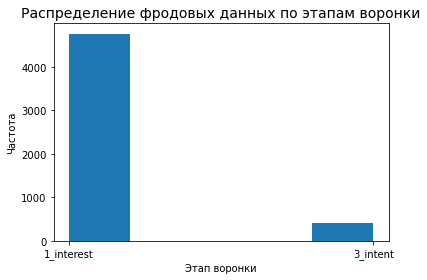

In [22]:
df = pd.read_csv('df_frod.csv')
plt.figure(figsize=(6,4))
plt.hist(df['funnel_stage'], bins=5)
plt.title('Распределение фродовых данных по этапам воронки', fontsize=14)
plt.xlabel('Этап воронки')
plt.ylabel('Частота')
plt.show()

In [23]:
data_funnel = df.drop(columns=['timestamp', 'profit', 'os', 'price']).groupby(['funnel_stage', 'ad_channel']).count()
data_funnel

user_id
funnel_stage ad_channel              
1_interest   banner               721
             native               152
             organic_traffic      642
             partner_network      492
             rich                  83
             search              1765
             video                903
3_intent     banner                59
             native                 3
             organic_traffic       68
             partner_network       42
             rich                   7
             search               237
             video                  1

### 3.1.2. Выводы исследования фродовых данных
Фродовые значения установлены только на этапах interest и intent, т.е. на начальных этапах взаимодействия пользователя с сайтом. 
Наибольшее количество - почти 92% на этапе интереса.
Причиной такого количества фродовых значений на этих этапах может быть обусловлено - 
1. "Накруткой" откликов со стороны рекламных каналов
2. Сбоем в обработки данных со стороны Интернет сетей.

Это логично, т.к. рекламные каналы получают свои деньги за количество откликов, т.е. прямой интерес в максимизации данных цифр. И если компания не проверяет их, то заплатит за их услуги значительно больше, чем должна. 

В приведенном примере, при отсутствии простейших проверок датасета, компания заплатила бы в три раза больше, чем необходимо.

При этом следует отметить, что фродовые данные есть по всем каналам в существенных объемах, что может свидетельствовать о каком-либо действительно сбое обработки данных, либо о том, что это стандартная процедура увеличения своих доходов со стороны любых рекламных каналом.

## 3.2. Исследование воронки продаж

#### 3.2.1. Визуализация воронки продаж по каналам коммуникаций

In [24]:
df_ = pd.read_csv('df_without_frod.csv')
df_chan = df_ \
        .groupby(['ad_channel', 'funnel_stage'], as_index=False) \
        .agg(user_count=('user_id', 'count')).sort_values(by='user_count', ascending=False)
df_chan.head(3)

,ad_channel,funnel_stage,user_count
20,search,1_interest,226432
21,search,2_consideration,134305
24,video,1_interest,98863


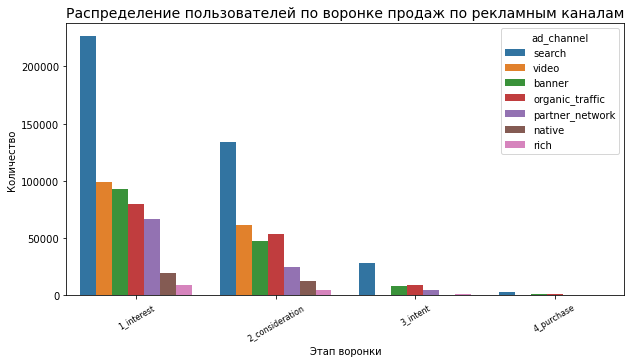

In [25]:
plt.figure(figsize=(10,5))
sns.barplot(x='funnel_stage', y='user_count', data = df_chan, hue='ad_channel')
plt.title('Распределение пользователей по воронке продаж по рекламным каналам', fontsize=14)
plt.xticks(fontsize=8 ,rotation=30)
plt.xlabel('Этап воронки', fontsize=10)
plt.ylabel('Количество', fontsize=10)
plt.show()

##### !!! Не очень хорошо виден результат при визуализации на гистограмме. Построим визуализацию на тепловой карте

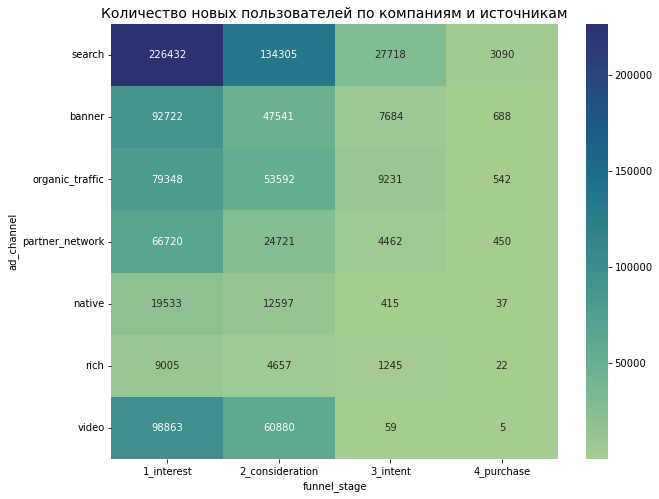

In [28]:
df_channel = df_.pivot_table(index='ad_channel', columns = 'funnel_stage', values ='user_id', aggfunc = 'count')
df_channel = df_channel[['1_interest', '2_consideration', '3_intent', '4_purchase']].sort_values(by='4_purchase', ascending=False)
plt.figure(figsize=(10,8))
sns.heatmap(df_channel, annot=True, fmt="g", cmap='crest')
plt.title('Количество новых пользователей по компаниям и источникам', fontsize=14)
plt.show()

### 3.2.2.  Выводы по исследованию воронки продаж 
Как видно из графика, неименее перспективным и ликвидным является канал "video". От него надо отказываться либо разбираться с причинами низкой эффективности более подробно.

Есть также вопросы и к баннерам.

Наиболее эффективными с точки зрения коэфф.полезного действия являются каналы "native" и "rich", но по ним достаточно мало откликов в целом.

В результате - 
- следует отказаться от канала video
- следует уделить внимание каналам баннер и organic_traffic с точки зрения определения путей повышения результативности отклика по ним.

## 3.3. Исследование затрат и прибыли по рекламным каналам

#### 3.3.1.  Графики затрат и прибыли по рекламным каналам на последнем этапе воронки продаж

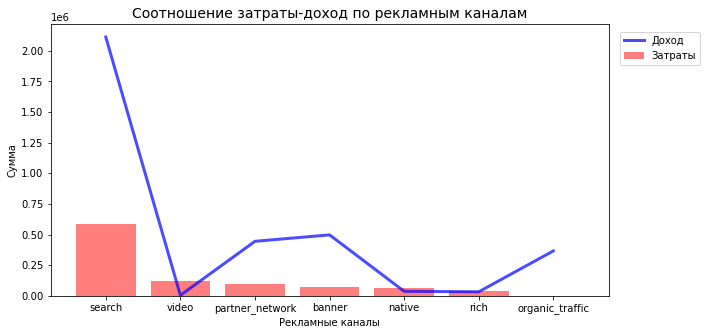

In [29]:
data_prof  = df_.groupby('ad_channel', as_index=False).agg(
                 all_count = ('user_id','count'), 
                 profit    = ('profit','sum'), 
                 costs     = ('price','sum')).sort_values(by='costs', ascending=False)
plt.figure(figsize=(10,5))
plt.bar(data_prof['ad_channel'], data_prof['costs'], label='Затраты', color='red', alpha=0.5)
plt.plot('ad_channel', 'profit', 
         data = data_prof, 
         label='Доход', color='blue', linewidth=3, alpha=0.7)
plt.title('Соотношение затраты-доход по рекламным каналам', fontsize=14)
plt.xlabel('Рекламные каналы')
plt.ylabel('Сумма')
plt.legend(loc=(1.02, 0.85))
plt.show()

### 3.3.2.  Выводы и рекомендации по затратам и прибыли по рекламным каналам
Из соотношения графиков явно следует, что
- убыточными каналами являются каналы video, native и rich
- остальные каналы являются прибыльными для компании.

Самые выгодные - каналы organic_traffic (нулевые издержки) и search.
На них и следует обращать внимание при разработке рекламной стратегии

## 3.4. Исследование операционных систем пользователей по каналам коммуникации

#### 3.4.1. График распределения операционной системы пользователя для каждого канала коммуникации

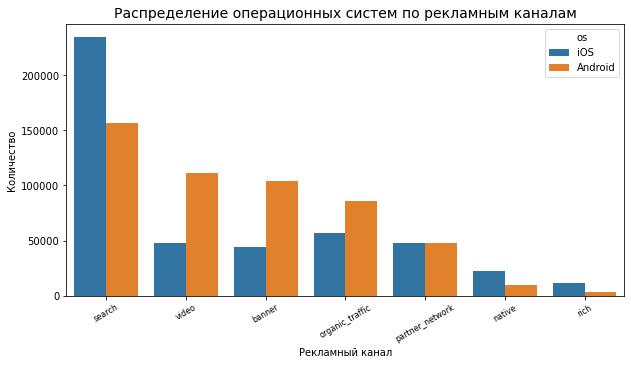

In [30]:
df_os = df_ \
        .groupby(['ad_channel', 'os'], as_index=False) \
        .agg(user_count=('user_id', 'count')).sort_values(by='user_count', ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(x='ad_channel', y='user_count', data = df_os, hue='os')
plt.title('Распределение операционных систем по рекламным каналам', fontsize=14)
plt.xticks(fontsize=8 ,rotation=30)
plt.xlabel('Рекламный канал', fontsize=10)
plt.ylabel('Количество', fontsize=10)
plt.show()

### 3.4.2. Выводы и рекомендации исследования операционных систем пользователей
Распределение использования операционных систем по рекламным каналам дает характеристику и тип пользователей на текущий момент.
Следует учитывать общие тенденции и ее перспективу изменения соотношения использования iOS и Android (предполагаемое изменение в России в сторону Android).

Но на момент проведения анализа - 
- преобладающее использование Android пользователям по каналам video, banner, organic_traffic
- примерно равное соотношение iOS и Android на канале partner_network
- преобладание использования iOS на каналах search, native и rich.

Предположительно исторически пользователи с iOS - более денежный класс пользователей, вип-клиенты и т.п.
пользователи с Android - пользователи с меньшим достатком.
Но в настоящее время ситуация значительно меняется и подобных жестких определений уже проводить нельзя.

    Проводились даже исследования особенностей людей, использующих разные ОС, можно их учитывать при оценке поведенческих действий людей при планировании рекламных кампаний -
    
Смартфон может многое сказать о характере владельца, если программно анализировать поведение пользователя и "обучить" приложение. Оказывается, у пользователей iPhone и Android разный характер – об этом говорят психологи. Даже самый надежный смартфон требует ремонта или профилактики. Оказывается, пользователи Android воспринимаются окружающими как более честные, и уступчивые люди, нежели владельцы iPhone. В свою очередь, любители iPhone воспринимаются окружающими как общительные и более открытые. 

Приверженцы операционной системы Android более индивидуальны и не любят быть похожими на всех – это проявляется даже в выборе одежды, которая приобретается необычного фасона, отличная от того, что носит большинство людей. 

Владельцев смартфонов iPhone отличает высокомерность и заносчивость – многие покупатели iPhone признались, что приобретение данной модели было выбрано по принципу его высокого статуса. 

Известно, что некоторые владельцы iPhone выражают свое социальное положение в обществе, демонстрируя свой новый телефон. 

Считается, что на характер человека оказывает влияние любая вещь, которой он пользуется. Так как телефон для многих людей является частью жизни, то по его модели, манере человека говорить, чистоте и техническому состоянию вполне можно судить о характере.

Источник: https://wek.ru/uchenye-issledovali-xarakter-polzovatelej-iphone-i-android